# Beta Bank

Los clientes de Beta Bank se están yendo, cada mes, poco a poco.
Necesitamos predecir si un cliente dejará el banco pronto. Contamos con los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

- *RowNumber*: índice de cadena de datos
- *CustomerId:* identificador de cliente único
- *Surname:* apellido
- *CreditScore:* valor de crédito
- *Geography:* país de residencia
- *Gender:* sexo
- *Age:* edad
- *Tenure:* período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)    
- *Balance:* saldo de la cuenta
- *NumOfProducts:* número de productos bancarios utilizados por el cliente
- *HasCrCard:* el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- *IsActiveMember:* actividad del cliente (1 - sí; 0 - no)
- *EstimatedSalary:* salario estimado
- *Exited:* El cliente se ha ido (1 - sí; 0 - no)

El objetivo de este proyecto es crear un modelo con el máximo valor *F1* posible, con un valor *F1* de al menos 0.59 para el conjunto de prueba.

## Exploracion inicial de datos

### Importación de librerías y archivos

In [1]:
# importamos las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler # escalado de características
from sklearn.utils import shuffle # mezclar datos
from sklearn.metrics import accuracy_score # exactitud
from sklearn.metrics import confusion_matrix # matriz de confusión
from sklearn.metrics import recall_score # recall
from sklearn.metrics import precision_score # precisión
from sklearn.metrics import f1_score #f1
from sklearn.metrics import roc_auc_score # auc roc

# algoritmos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
# cargamos los datos del dataset
data = pd.read_csv('./datasets/Churn.csv')

In [3]:
# mostramos la estructura y contenido del dataset
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Podemos ver que la columna 'Tenure' contine valores ausentes. Esta columna hace referencia al número de años que el cliente ha mantenido un deposito a plazo fijo. Por lo es posible que los cliente que no tengan valores en esta columna, no hayan cumplido ni un año dentro del banco o sean cliente inactivos. Dado este escenario, rellenaremos los valores ausentes con ceros.

Adicional a esto, podemos ver que los datos están distribuidos normalmente, a excepción de la columna 'Balance' que tiene un sesgo hacía la izquierda, ya que la media es considerablemente menor que la mediana.

## Preparación de los datos

### Valores ausentes

In [6]:
# llenamos con cero los valores ausentes para la columna 'Tenure'
data.fillna(0, inplace = True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Valores duplicados
Ahora que no existen valores ausentes, veamos si existen valores duplicados

In [8]:
print('Numero de valores duplicados:', data.duplicated().sum())

Numero de valores duplicados: 0


### OHE
Para predecir que clientes dejarán el banco, ocuparemos la regresión logística. Hay que recordar que este algoritmo determina la categoría utilizando una fórmula que consta de características numéricas. Debido a que nuestros datos contienen características categoricas, transformaremos las características categóricas en numéricas con "One-Hot Encoding".  

Para simplificar y optimizar los datos, eliminaremos las columnas que no aportan valor predictivo al modelo, como `RowNumber`, `CustomerId` y `Surname`, antes de realizar la codificación OHE. Estas columnas no contienen información que pueda ayudar al modelo a predecir si un cliente dejará el banco o no, y mantenerlas podría añadir ruido al modelo o aumentar innecesariamente la dimensionalidad de los datos.

In [9]:
# Eliminamos las columnas que no contribuyen a las predicciones
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False


### Segmentación de los datos
Debido a que no contamos con un conjunto de prueba, segmentaremos los datos fuente en tres conjutos: un conjunto de entrenamiento, uno de validación y uno de prueba. Ya que el conjunto de entrenamiento debe ser más grande y el conjunto de prueba debe ser del mismo tamaño que el conjuto de validación, usaremos una proporción 3:1:1 (60%:20%:20%).  
Pero antes separaremos el conjunto en dos subconjuntos, uno con características y otro con el objetivo.

In [11]:
# conjuntos de características y objetivo
features = data_ohe.drop('Exited',axis=1)
target = data_ohe['Exited']

In [12]:
# dividimos el dataset en dos conjuntos, entrenamiento y (validación + prueba)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

In [13]:
# dividimos el dataset temporal en el conjunto de validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

In [14]:
# mostramos el tamaño de los conjuntos
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


### Estandarización de caraterísticas
También podemos observar que las características tiene escalas diferentes y debido a que necesitamos que todas las características sean igualmente importantes, realizaremos un escalado de características a travez de la estandarización de los datos, incluyendo todas las carácteristicas númericas, excepto las booleanas que contiene 0's y 1's.

In [15]:
# seleccionamos solo las columnas con datos númericos
numeric = ["CreditScore", "Tenure", "Age", "Balance", "NumOfProducts", "EstimatedSalary"]

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# Realizamos la transformación y convertimos a float64
features_train[numeric] = scaler.transform(features_train[numeric]).astype(float)
features_valid[numeric] = scaler.transform(features_valid[numeric]).astype(float)
features_test[numeric] = scaler.transform(features_test[numeric]).astype(float)

pd.options.mode.chained_assignment = None

## Entrenamiento sin equilibrio de clases
Examinaremos el equilibrio entre clases. Para esto, entrenaremos el modelo y comprobaremos su exactitud.

In [16]:
model = DecisionTreeClassifier(random_state=12345) 
model.fit(features_train,target_train)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(predicted_valid, target_valid)

print(accuracy_valid)

0.7865


La exactitud es bastante alta pero hagamos una prueba de cordura. 

Primero, verifiquemos con qué frecuencia la variable objetivo contiene la clase "1" o "0".

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


<Axes: xlabel='Exited'>

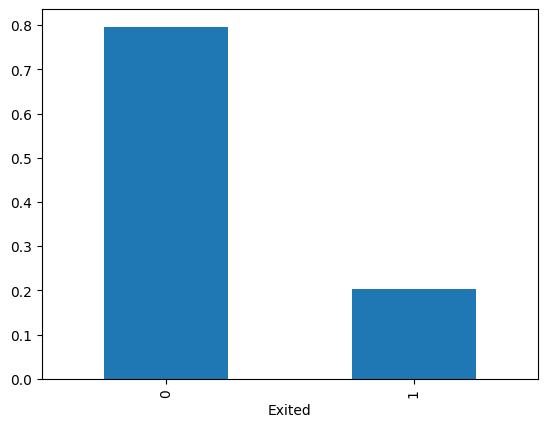

In [17]:
class_frequency = data['Exited'].value_counts(normalize=True) # frecuencias relativas

print(class_frequency)

class_frequency.plot(kind='bar')

Aproximadamente el 20% de los clientes abandonaron el banco.

Ahora analizaremos las frecuencias de clase de las predicciones del modelo.

0    0.7985
1    0.2015
Name: proportion, dtype: float64


<Axes: >

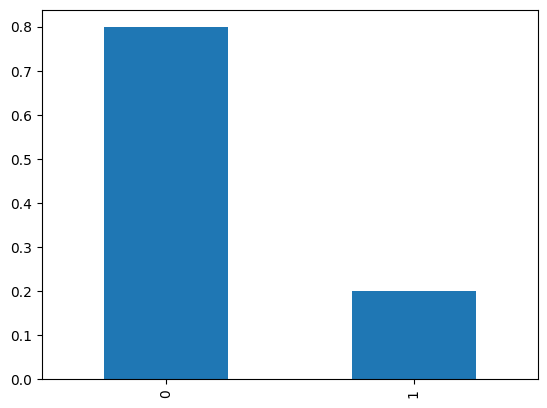

In [18]:
# para hacer que value_counts() funcione, convertimos los resultados a pd.Series
predicted_valid_series = pd.Series(predicted_valid)
class_frequency = predicted_valid_series.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Parece que el modelo mantiene una proporción de valores positivos y negativos similares a los proporcionados por el dataset original, como si simplemente estuviera eligiendo la clase más común. 

Hagmos una prueba de cordura, comparando la exactitud de un modelo constante con la exactitud de nuestro modelo.

In [19]:
target_constant = pd.Series([0]*features.shape[0])

print(accuracy_score(target, target_constant))

0.7963


El modelo constante muestra una mejor exactitud en comparación con nuestro modelo, lo que sugiere que nuestro modelo podría no estar capturando patrones significativos en los datos. Esto podría deberse a un desequilibrio de clases, por lo que emplearemos otra métrica diferente a la exactitud para evaluar nuestro modelo.

### Matriz de confusión
Inicialmente veamos la matriz de confusión para el modelo.

In [20]:
print(confusion_matrix(target_valid,predicted_valid))

[[1376  206]
 [ 221  197]]


El modelo se inclina por las respuestas negativas y, aunque en la mayoría de los casos acierta, esto no es útil para hacer una buena predicción.

### Valor F1
Vamos a calcular el valor F1 para el modelo. Recordemos que el valor F1 es la media armónica entre el recall y la precisión. El recall mide qué proporción de los positivos reales fueron correctamente identificados, mientras que la precisión indica qué proporción de las predicciones positivas fue realmente correcta.

In [21]:
print(f1_score(target_valid, predicted_valid))

0.47990255785627284


El valor F1 es muy bajo, lo que significa que muchas de las predicciones positivas son incorrectas y muchos de los casos positivos reales no fueron identificados. Esto podría deberse a una insuficiencia de casos positivos en los datos de entrenamiento.

### AUC-ROC
Asimismo, calculemos el valor AUC-ROC, el cual nos muestra la diferencia entre nuestro modelo y un modelo aleatorio en términos de la relación entre la tasa de falsos positivos y la tasa de verdaderos positivos

In [22]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(roc_auc_score(target_valid, probabilities_one_valid))

0.6705384741015855


El modelo presenta un valor AUC-ROC muy bajo, apenas superior al de un modelo aleatorio. Esto indica que tiene dificultades para diferenciar entre las clases positivas y negativas, lo que sugiere que no está capturando adecuadamente los patrones y características distintivas entre ambas clases. Veamos si podemos mejorarlo.

## Mejorar la calidad del modelo 

### Ajuste de peso de clase
Hagamos que las clases con menos frecuencia tengan un mayor peso utilizando el atributo 'class_weight'.

In [23]:
# arbol de decisión
for depth in range(1,10):  # selecciona el rango de la profundidad
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    
    predicted_valid = model_tree.predict(features_valid)
    print("max_depth:", depth)
    print('F1:', f1_score(target_valid, predicted_valid))
    
    probabilities_valid = model_tree.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
    
    print()

max_depth: 1
F1: 0.49949031600407745
AUC-ROC: 0.6925565119556736

max_depth: 2
F1: 0.541015625
AUC-ROC: 0.7501814673449512

max_depth: 3
F1: 0.541015625
AUC-ROC: 0.7980472601455368

max_depth: 4
F1: 0.5277777777777778
AUC-ROC: 0.8191035210713832

max_depth: 5
F1: 0.5963791267305645
AUC-ROC: 0.8310244134068074

max_depth: 6
F1: 0.5581835383159887
AUC-ROC: 0.7999390572166538

max_depth: 7
F1: 0.556
AUC-ROC: 0.7937290934496337

max_depth: 8
F1: 0.5401174168297456
AUC-ROC: 0.7745117016192936

max_depth: 9
F1: 0.5349065880039331
AUC-ROC: 0.7661052268644258



Intentemos con la regresión logística.

In [24]:
#regresión logística
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

#valor F1
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.4888888888888889


In [25]:
# AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC: 0.7635798063138539


Logramos alcanzar nuestro objetivo, consiguiente un valor F1 de 0.59. Utilizando un arbol de decisión con una profundidad máxima de 5.
Veamos si podemos mejorar este resultado con otra técnica.

### Sobremuestreo
Hagamos un sobremuestreo de los datos, duplicando la clase con menos frecuencia (las observaciones positivas)

In [26]:
# función de sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [27]:
# aplicamos el sobremuestreo
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

In [28]:
# arbol de decisión
modelo = DecisionTreeClassifier(random_state=12345)
modelo.fit(features_upsampled, target_upsampled)

# valor F1
predicted_valid = modelo.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.45968712394705175


In [29]:
# AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC: 0.7635798063138539


Vemos que el valor F1 es incluso peor que el modelo original cuando realizamos un sobremuestreo.  
Intentemos cambiando la profundidad del arbol.

In [30]:
# arbol de decisión
for depth in range(1,11):  # selecciona el rango de la profundidad
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predicted_valid = model_tree.predict(features_valid)
    print("max_depth:", depth)
    print('F1:', f1_score(target_valid, predicted_valid))
    
    # AUC-ROC
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
    
    print()

max_depth: 1
F1: 0.3457402812241522
AUC-ROC: 0.7635798063138539

max_depth: 2
F1: 0.49217002237136465
AUC-ROC: 0.7635798063138539

max_depth: 3
F1: 0.4263356718834323
AUC-ROC: 0.7635798063138539

max_depth: 4
F1: 0.4247020585048754
AUC-ROC: 0.7635798063138539

max_depth: 5
F1: 0.4901293396868618
AUC-ROC: 0.7635798063138539

max_depth: 6
F1: 0.4655612244897959
AUC-ROC: 0.7635798063138539

max_depth: 7
F1: 0.5210608424336973
AUC-ROC: 0.7635798063138539

max_depth: 8
F1: 0.4801730353280461
AUC-ROC: 0.7635798063138539

max_depth: 9
F1: 0.49321266968325794
AUC-ROC: 0.7635798063138539

max_depth: 10
F1: 0.48687350835322196
AUC-ROC: 0.7635798063138539



No logramos hacer una mejoría en el valor.  
Cambiemos el número de veces que se duplicará la clase para encontrar el valor más optimo.

In [31]:
for repeat in range(1,11):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    print('repeticiones:',repeat)
    modelo = DecisionTreeClassifier(random_state=12345)
    modelo.fit(features_upsampled, target_upsampled)
    predicted_valid = modelo.predict(features_valid)
    print('F1:', f1_score(target_valid, predicted_valid))
    
    # AUC-ROC
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
    
    print()

repeticiones: 1
F1: 0.47990255785627284
AUC-ROC: 0.7635798063138539

repeticiones: 2
F1: 0.4963680387409201
AUC-ROC: 0.7635798063138539

repeticiones: 3
F1: 0.4969097651421508
AUC-ROC: 0.7635798063138539

repeticiones: 4
F1: 0.4575645756457565
AUC-ROC: 0.7635798063138539

repeticiones: 5
F1: 0.48166259168704156
AUC-ROC: 0.7635798063138539

repeticiones: 6
F1: 0.4724602203182375
AUC-ROC: 0.7635798063138539

repeticiones: 7
F1: 0.4701583434835566
AUC-ROC: 0.7635798063138539

repeticiones: 8
F1: 0.49215922798552475
AUC-ROC: 0.7635798063138539

repeticiones: 9
F1: 0.48198757763975153
AUC-ROC: 0.7635798063138539

repeticiones: 10
F1: 0.45968712394705175
AUC-ROC: 0.7635798063138539



Parece que con un menor número de repeticiones, obtenemos una mejor calidad, pero el valor F1 aún está lejos de nuestro objetivo.  
Intentemos con la regresión logística.

In [32]:
# regresión logistica
modelo = LogisticRegression(random_state=12345, solver='liblinear' )
modelo.fit(features_upsampled, target_upsampled)
predicted_valid = modelo.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.4198895027624309
AUC-ROC: 0.7635798063138539


Aunque el sobremuestreo es una técnica común para manejar el desequilibrio, en este caso no mejoró significativamente el rendimiento de tu modelo. A veces, el sobremuestreo puede llevar al sobreajuste, especialmente con modelos como los árboles de decisión.  
Usaremos otro enfoque, esta vez aplicaremos un submuestreo, reduciendo las observaciones de la clase predominante.

### Submuestreo

In [33]:
#función de submuestreo
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [34]:
# aplicamos el submuestreo
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.6
)

In [35]:
# arbol de decisión
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.488659793814433
AUC-ROC: 0.6839353008426134


El valor F1 es aún más bajo que con el sobremuestreo. Cambiemos la profundidad del arbol y veamos si conseguimos un mejor resultado.

In [36]:
# arbol de decisión
for depth in range(1,11):  # selecciona el rango de la profundidad
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predicted_valid = model_tree.predict(features_valid)
    print("max_depth:", depth)
    print('F1:', f1_score(target_valid, predicted_valid))
    
    # AUC-ROC
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
    
    print()

max_depth: 1
F1: 0.49949031600407745
AUC-ROC: 0.6839353008426134

max_depth: 2
F1: 0.5217391304347826
AUC-ROC: 0.6839353008426134

max_depth: 3
F1: 0.5466666666666666
AUC-ROC: 0.6839353008426134

max_depth: 4
F1: 0.5607940446650124
AUC-ROC: 0.6839353008426134

max_depth: 5
F1: 0.5478260869565217
AUC-ROC: 0.6839353008426134

max_depth: 6
F1: 0.5477178423236515
AUC-ROC: 0.6839353008426134

max_depth: 7
F1: 0.5836477987421383
AUC-ROC: 0.6839353008426134

max_depth: 8
F1: 0.59
AUC-ROC: 0.6839353008426134

max_depth: 9
F1: 0.5302445302445302
AUC-ROC: 0.6839353008426134

max_depth: 10
F1: 0.5483476132190942
AUC-ROC: 0.6839353008426134



Pudimos alcanzar un valor F1 de 0.59, sin embargo el modelo con los datos sin el sobremuestreo sigue siendo ligeramente mejor.

In [37]:
# regresión logistica
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.42219215155615697
AUC-ROC: 0.7609409686726872


Como podemos observar, el modelo con el mejor valor F1 se obtuvo al ajustar el peso de las clases, logrando también el mejor valor AUC-ROC. Por lo tanto, seleccionaremos un árbol de decisión con una profundidad de 5 como nuestro modelo definitivo.

## Prueba final
Realizaremos la prueba de nuestro modelo, utilizando el conjunto de prueba.

In [38]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model_tree.fit(features_train, target_train)

predicted_test = model_tree.predict(features_test)
print('F1:', f1_score(target_test, predicted_test))

probabilities_test = model_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.5809128630705395
AUC-ROC: 0.8355347481752318


Obtuvimos un valor F1 ligeramente menor en comparación con el conjunto de validación, pero el valor AUC-ROC mejoró

## Conclusión

El desequilibrio de clases puede afectar la calidad de un modelo; sin embargo, necesitamos métricas específicas para detectar estos defectos. Las métricas de recall y precisión nos ayudan a entender mejor cómo actúa el algoritmo, al igual que la matriz de confusión.

Tanto el valor F1 como el AUC-ROC combinan los conceptos de estas métricas y permiten evaluar la calidad del modelo. Es importante señalar que, para obtener resultados óptimos en estas métricas, es necesario realizar pruebas con distintos parámetros y modelos. Cada conjunto de datos tiene su propia complejidad, y lo que funciona bien para un modelo podría no dar el mejor resultado para otro.